In [27]:
import torch 
import torchvision
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.auto import tqdm

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data 

In [29]:
import os 
import zipfile
from pathlib import Path 
import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir(): 
    print(f"{image_path} directory exists.")
else: 
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f: 
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    with zipfile.ZipFile(data/"pizza_steak_sushi.zip", "r") as zip_ref: 
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)
        
    os.remove(data_path/"pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [30]:
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

# 2. Create datasets, DataLoader

### 2.1 Creating a transform for torchvision.models (manual creation)

In [31]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [32]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
test_data = datasets.ImageFolder(test_dir, transform=manual_transforms)   

In [33]:
import os
torch.manual_seed(42)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

class_names = train_data.classes
class_to_idx = train_data.class_to_idx

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1dd2db9c050>,
 <torch.utils.data.dataloader.DataLoader at 0x1dd2d330850>)

### 2.2 Creating a transform for torchvision.models (auto creation)

1. The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.
2. However, the tradeoff of using automatically created transforms is a lack of customization (if you want to customize you can use manual creation.)

In [34]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [35]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [36]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# 3. Getting a pretrained model

### 3.2 Setup a pretrained model

In [37]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [38]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting summary of our model with torchinfo.summary()

* model: the model we'd like to get a summary of 
* input_size: the shape of data we'd like to pass to model
* col_names: various information columns we'd like to see about model
* col_width: how wide columns should be for the summary
* row_settings: what features to show in a row

In [39]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit out needs

In [40]:
for param in model.features.parameters():
    param.requires_grad = False

In [41]:
# Set manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [42]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=5,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param # Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3] --    Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --    False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --    False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864) False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)  False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --    --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --    False
│    │    └─MBConv (0)                                       [32, 32, 112, 112] [32, 16, 112, 112] (1,448) False
│    └─Sequential (2)   

# 4. Train model

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
from typing import Tuple, List, Dict

torch.manual_seed(42)
torch.cuda.manual_seed(42)

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass 
        y_pred = model(X)
        # 2. Calculate loss and accumulate loss 
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=torch.device) -> Tuple[float, float]:
    
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Put data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred)
            
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [45]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0988 | train_acc: 0.4258 | test_loss: 0.9227 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8713 | train_acc: 0.7617 | test_loss: 0.8044 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7820 | train_acc: 0.7617 | test_loss: 0.7429 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7298 | train_acc: 0.7461 | test_loss: 0.6512 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6366 | train_acc: 0.7812 | test_loss: 0.6271 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5937 | train_acc: 0.7812 | test_loss: 0.5597 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.5405 | train_acc: 0.9219 | test_loss: 0.5299 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5512 | train_acc: 0.8047 | test_loss: 0.5260 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5706 | train_acc: 0.7852 | test_loss: 0.4930 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.5209 | train_acc: 0.8086 | test_loss: 0.4194 | test_acc: 0.8655
[INFO] Total training time: 119.665 seconds


# 5. Evaluate model by plotting loss curves

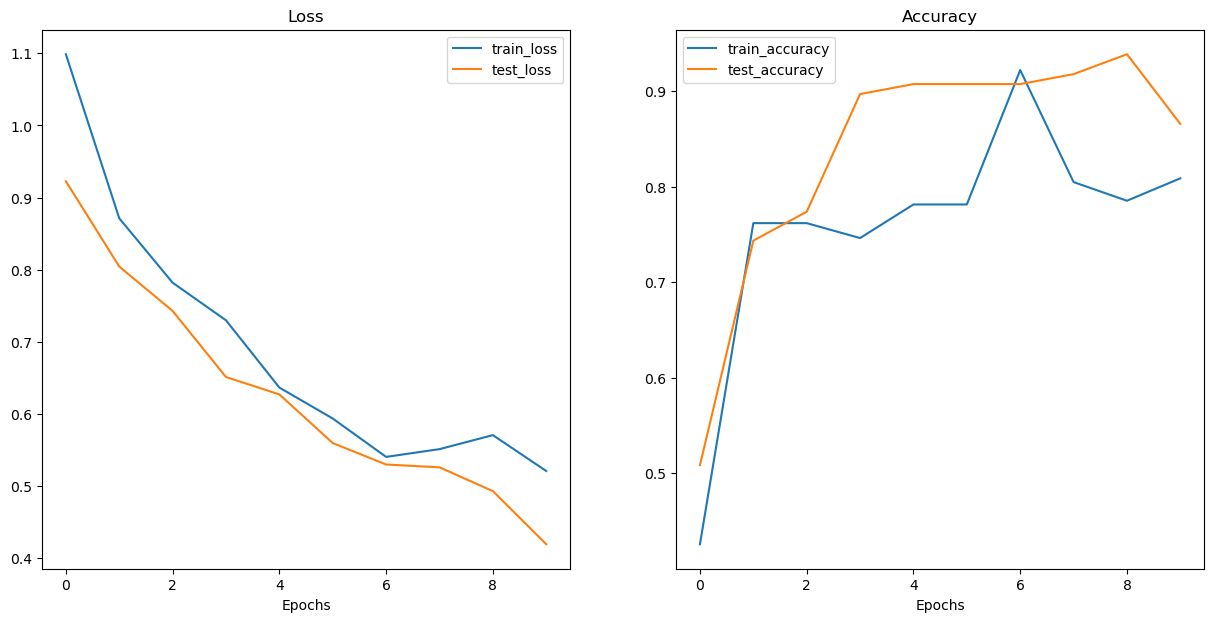

In [46]:
try: 
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f: 
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves
    
plot_loss_curves(results)

# 6. Make predictions on images from test set 

In [49]:
from PIL import Image
from typing import Tuple, List

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int],
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    # Open Image
    img = Image.open(image_path)
    
    # Create transformation for image(if one does not exist)
    if transform is not None:
        image_transform = transform
    else: 
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    # Predict on Image
    # Make sure the model is on the target device
    model.to(device)
    
    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode(): 
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
        
    # Convert logits -> prediction probabilities (softmax for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # Plot image with predicted label and probability
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}", fontsize=20)
    plt.axis(False)

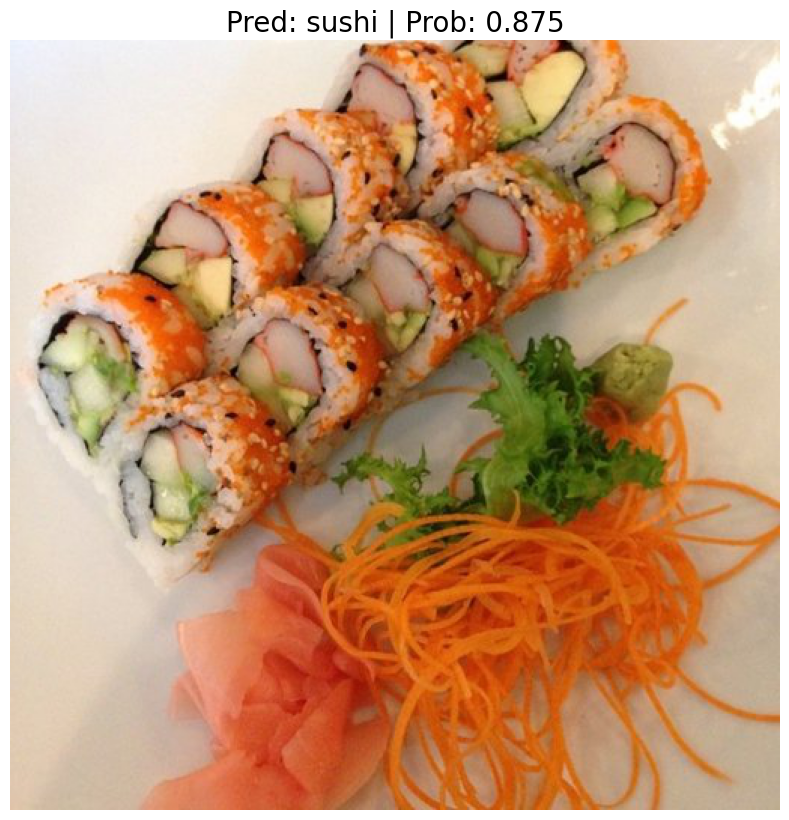

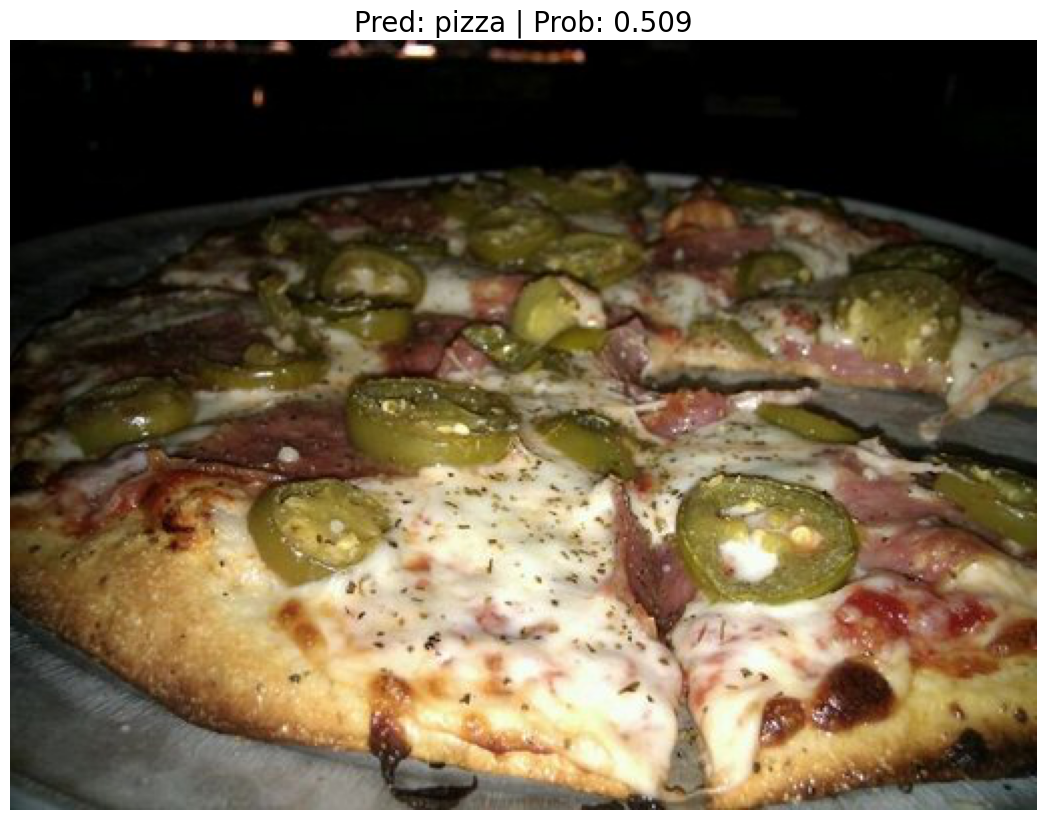

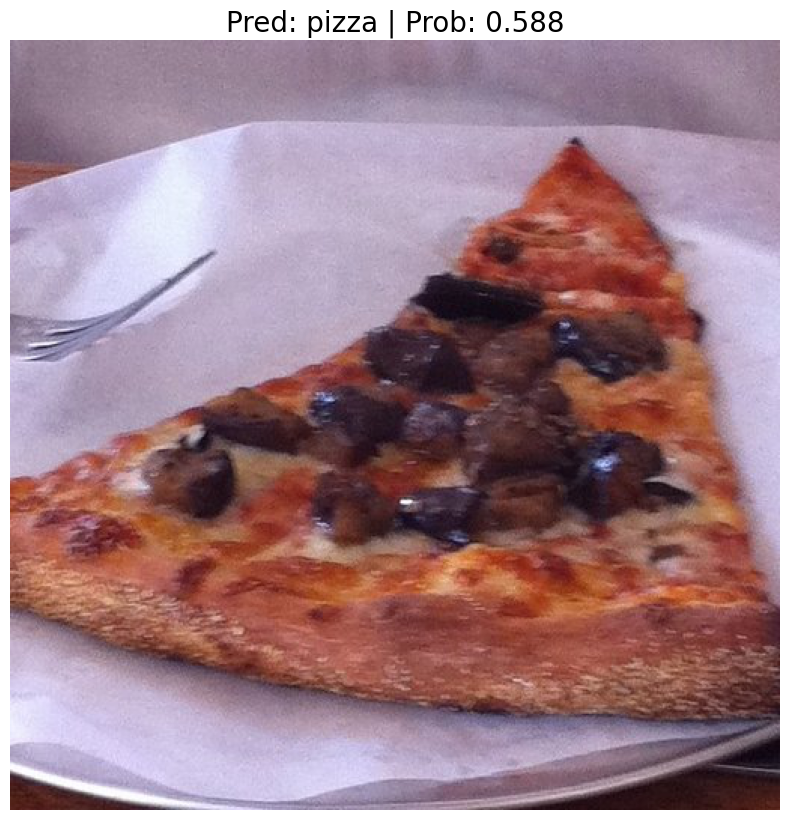

In [52]:
import random
num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_image_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        transform=weights.transforms(),
                        class_names=class_names,
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

data\04-pizza-dad.jpeg already exists, skipping download.


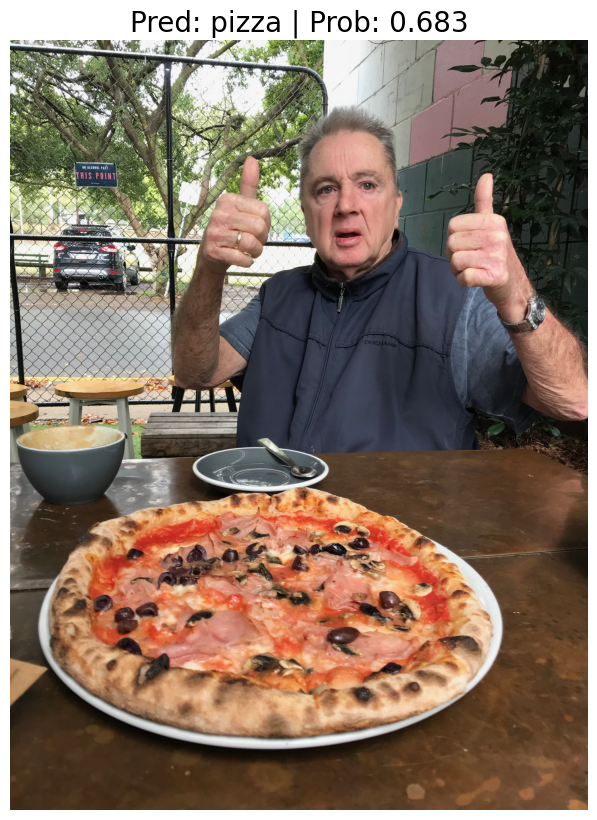

In [55]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model, 
                    image_path=custom_image_path,
                    transform=weights.transforms(),
                    class_names=class_names,
                    image_size=(224, 224))